## Pandas Implementation of a Fisher-transformed Rolling Pearson Correlation for PRx

Merck, Spring 2020

A Fisher-transformed rolling Pearson correlation is useful for computing the cerebral pressure reactivity index (PRx) from intracranial pressure (ICP) and mean arterial pressure (MAP) values.  PRx provides an index of patient cerebral pressure autoregulation after traumatic brain injury.

Steiner, Luzius A., Marek Czosnyka, Stefan K. Piechnik, Piotr Smielewski, Doris Chatfield, David K. Menon, and John D. Pickard. “Continuous Monitoring of Cerebrovascular Pressure Reactivity Allows Determination of Optimal Cerebral Perfusion Pressure in Patients with Traumatic Brain Injury.” Critical Care Medicine 30, no. 4 (April 2002): 733–38. https://doi.org/10.1097/00003246-200204000-00002.


In [234]:
import numpy as np
import pandas as pd

def fisher_transformed_rolling_pearson(obs1, obs2, w_sz):
    # Compares correlation of two sets of data samples
    # over a sliding window and returns a set of z-scores

    # Format as a data frame with 2 columns
    df = pd.DataFrame(np.array([obs1, obs2]).T)
    
    # Compute correlation along moving window
    _rp = df.rolling(w_sz).corr().loc[:,0][:,1]
    
    # Compute the Fisher r->z transform
    with np.errstate(invalid='ignore'):
        _ftrp = np.arctanh(_rp)
    
    return _ftrp.to_numpy()


def compute_prx(df, 
                sampling_target_rate="5T",
                correlation_window_size=5, 
                title=None):

    # Resample time series to appropriate frequency
    _df = df.resample(sampling_target_rate).mean()
    
    prx = fisher_transformed_rolling_pearson(
        _df["map"].to_numpy(),
        _df["icp"].to_numpy(),
        correlation_window_size
    )
    _df["prx"] = prx
    
    _title = f"{title}-{sampling_target_rate}-{correlation_window_size}"         

    print(_title)
    print(_df.head())    
    _df.plot(subplots=True, title=_title)

    mu = _df["prx"].mean()
    print(f"Mean PRx: {mu}")

sampling_target_rate = "10T"
correlation_window_size = 5


### Captured Data Example

This reads in a dataset from a `.csv` file and computes PRx.  Sample data is 6 hours with a 2 sec period.  Headers should be `sec`, `icp`, and `map`.


Observed-10T-5
                       map        icp       prx
sec                                            
1970-01-01 00:00:00  90.00  14.016667       NaN
1970-01-01 00:10:00  90.00  10.603333       NaN
1970-01-01 00:20:00  90.00  10.763333       NaN
1970-01-01 00:30:00  88.58  11.206667       NaN
1970-01-01 00:40:00  88.00   1.256667  1.017767
Mean PRx: -0.0006525706671639169


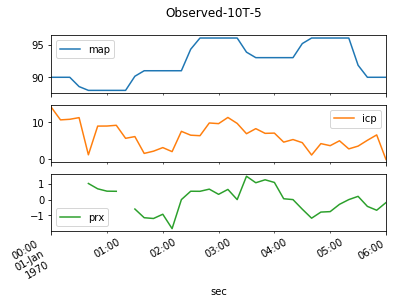

In [235]:

def get_csv_obs(fn):
    # Data comes in seconds
    df = pd.read_csv(fn)
    df = df.astype({"sec": 'datetime64[s]'})
    df = df.set_index("sec")
    return df

title = "Observed"
df = get_csv_obs("test.csv")
compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)


### Correlated Data Examples

These examples generate datasets of similar size to the live data with artificially induced correlation.

This example simulates independent variables; the mean prx is usually near 0


Independent-10T-5
                            icp        map       prx
1970-01-01 00:00:00  100.173073   9.932188       NaN
1970-01-01 00:10:00   99.920899  10.072572       NaN
1970-01-01 00:20:00   99.786470   9.950330       NaN
1970-01-01 00:30:00   99.915042  10.070151       NaN
1970-01-01 00:40:00  100.122306  10.009720 -0.270567
Mean PRx: -0.006066091460576545


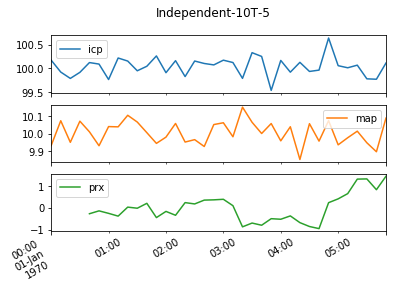

In [236]:

def get_correlated_obs(mean, cov, n_obs):
    obs = np.random.multivariate_normal(mean, cov, n_obs).T
    df = pd.DataFrame(
        {"icp": obs[0,:],
         "map": obs[1,:]},
        index = pd.date_range(start=0, 
                              periods=n_obs, 
                              freq="2S")
    )
    return df
    
n_obs = 60 * 60 * 6 // 2  # 6hrs of 1 obs/2 sec
mean = [100,10]  # MAP is O(100), ICP is O(10)

title = "Independent"
cov = [[10, 0], [0, 1]]

df = get_correlated_obs(mean, cov, n_obs)
compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)


This example simulates correlated variables; the mean prx is usually greater than 0, which is _bad_.


Correlated-10T-5
                            icp        map      prx
1970-01-01 00:00:00   99.994383  10.052872      NaN
1970-01-01 00:10:00   99.910874  10.002785      NaN
1970-01-01 00:20:00   99.690032   9.844687      NaN
1970-01-01 00:30:00  100.051965   9.947283      NaN
1970-01-01 00:40:00   99.869558   9.933366  0.96041
Mean PRx: 0.9266362154917083


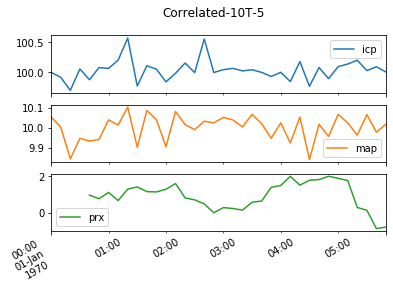

In [237]:

title = "Correlated"
cov = [[10, 2], [2, 1]]

df = get_correlated_obs(mean, cov, n_obs)
compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)


This example simulates anti-correlated variables; the mean prx is usually less than 0, which is _good_.


Anti-correlated-10T-5
                            icp        map       prx
1970-01-01 00:00:00  100.261373   9.855515       NaN
1970-01-01 00:10:00   99.855056   9.989415       NaN
1970-01-01 00:20:00   99.905233  10.041457       NaN
1970-01-01 00:30:00   99.884314  10.065286       NaN
1970-01-01 00:40:00  100.053579  10.051286 -1.027437
Mean PRx: -0.6539477821661128


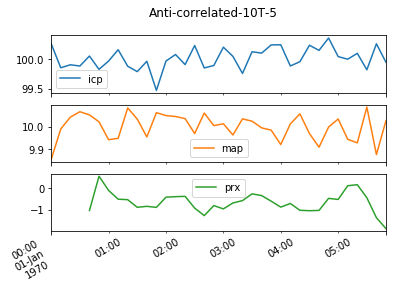

In [238]:
title = "Anti-correlated"
cov = [[10, -2], [-2, 1]]

df = get_correlated_obs(mean, cov, n_obs)
compute_prx(df,
            sampling_target_rate,
            correlation_window_size,
            title)
